<h1 style="font-size: 40px">
    <b>MLG382: Group A</b>
</h1>

<h1>
    <b>Group Members:</b>
</h1>
<ul>
    <li>Andre Burger             [ 577387 ]</li>
    <li>Acseivire Mboto          [ 576094 ]</li>
    <li>Lethabo Thapelo Phofa    [ 577636 ]</li>
    <li>Tadiwanashe Nyoka        [ 5776332 ]</li>
    <li>Thubelihle Nkuna         [ 577200 ]</li>
</ul>

__If you would like to verify the model or just want to explore, then you can visit our [GitHub Repo](https://github.com/andreburg/MLG382-Project1).__

<h2>
        <b>Project 1:</b> Loan Status Classifier
</h2>

In [1]:
#!pip install numpy pandas matplotlib skimpy scikit-learn tensorflow plotly seaborn shap xgboost

__Import relevant libraries__

In [2]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from skimpy import clean_columns
import matplotlib.pyplot as plt
import tensorflow as tf
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import shap

# 1. Business Understanding

## 1.1. Problem

The business problem at hand involves BC Finance company seeking to automate their home loan eligibility process based on customer information provided during online applications. The company operates across urban, semi-urban, and rural areas, and currently, the loan approval process involves manual validation of customer details like gender, marital status, education, income, credit history, and more. To streamline this process, BC Finance aims to develop a real-time automated system that can quickly assess customer eligibility for specific loan amounts. By leveraging data analytics and potentially deep learning algorithms, the company intends to identify distinct customer segments eligible for loans, optimizing their targeting efforts and enhancing operational efficiency in loan processing and approval.

## 1.2. Read and Clean Data

### 1.2.1. Read and view data

In [3]:
df = pd.read_csv('../data/raw_data.csv')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


### 1.2.2. Clean column names

In [4]:
df = clean_columns(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   loan_id             614 non-null    object 
 1   gender              601 non-null    object 
 2   married             611 non-null    object 
 3   dependents          599 non-null    object 
 4   education           614 non-null    object 
 5   self_employed       582 non-null    object 
 6   applicant_income    614 non-null    int64  
 7   coapplicant_income  614 non-null    float64
 8   loan_amount         592 non-null    float64
 9   loan_amount_term    600 non-null    float64
 10  credit_history      564 non-null    float64
 11  property_area       614 non-null    object 
 12  loan_status         614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


### 1.2.3. Understand features

In [5]:
def print_unique_column_values(df):
    print("Unique Column Values")
    print('='*25)
    for line in [f'{col:<20} {(len(df[col].unique())) - (1 if df[col].isnull().sum() > 0 else 0)}' for col in df.columns]:
        print(line)

print_unique_column_values(df)

Unique Column Values
loan_id              614
gender               2
married              2
dependents           4
education            2
self_employed        2
applicant_income     505
coapplicant_income   287
loan_amount          203
loan_amount_term     10
credit_history       2
property_area        3
loan_status          2


__Is `property_area` ordinal or categorical?__

In [6]:
df.property_area.unique()

array(['Urban', 'Rural', 'Semiurban'], dtype=object)

We will assume that property area is __ordinal__ as it ranges from __NOT__ Urban, __SEMI__ Urban, __ENTIRELY__ Urban, or alternatively `0`, `1`, `2`

__Is `dependents` ordinal or categorical?__

In [7]:
df.dependents.unique()

array(['0', '1', '2', '3+', nan], dtype=object)

We will assume that dependents is __ordinal__ as it ranges from `0` to `3+` and we can use this to tell us the level of dependents someone has

__Convert Columns To Correct DataTypes__\
We want to keep our numeric data numeric, and ensure that out categorical, ordinal, and boolean values are objects.\
__Examining the head and information of our data we can assume:__
- [x] `loan_id`: Unique String (Index). (We are going to drop as this will not influence our model in any significant way)
- [x] `gender`: Boolean.
- [x] `married`: Boolean.
- [x] `dependents`: Ordinal.
- [x] `education`: Binary.
- [x] `self_employed`: Boolean.
- [x] `applicant_income`: Numeric.
- [x] `coapplicant_income`: Numeric.
- [x] `loan_amount`: Numeric.
- [x] `loan_amount_term`: Numeric. (There are standard terms, but we assume that a person can specify their own term)
- [ ] `credit_history`: Boolean. (Currently is Float)
- [x] `property_area`: Ordinal. (The data will reflect the level of "urban" that an area is in which a person lives)
- [x] `loan_status`: Boolean. (Either accepted or denied)


In [8]:
df.credit_history = df.credit_history.astype(str)
df.credit_history.dtype.name

'object'

- [x] `credit_history`: Boolean.

We are going to drop the `loan_id` column, as the values are always going to be unique and thus will not help provide any insightfull information.

In [9]:
df.drop(columns=['loan_id'], axis=1, inplace=True)

### 1.2.4.Treat null values

In [10]:
print("Null Values:", '\n'+'='*50)
df.isnull().sum()

Null Values: 


gender                13
married                3
dependents            15
education              0
self_employed         32
applicant_income       0
coapplicant_income     0
loan_amount           22
loan_amount_term      14
credit_history         0
property_area          0
loan_status            0
dtype: int64

There are both categorical and numeric features that has missing data and needs to be treated effectively as too ensure a reliable model.

__Split data by type__

We will split our data into 2 categories, `"numerical"` and `"categorical"`, this will allow us to work with and transform all of our data in a systemic way. \
We are able to do this because all of our `"categorical"` data is either binary or ordinal, allowing us to label encode all of them.

In [11]:
df.credit_history = df.credit_history.astype(str)
df.loc[df.credit_history == 'nan','credit_history'] = np.nan

categorical_columns = df.select_dtypes(include=['object', 'boolean']).columns
numeric_columns = df.select_dtypes(exclude=['object', 'boolean']).columns

### 1.2.5. Impute missing data

In [12]:
for col in categorical_columns:
    df[col] = df[col].fillna(df[col].mode()[0])

df[categorical_columns].isnull().sum()

gender            0
married           0
dependents        0
education         0
self_employed     0
credit_history    0
property_area     0
loan_status       0
dtype: int64

In [13]:
for col in numeric_columns:
    df[col] = df[col].fillna(df[col].median())

df[numeric_columns].isnull().sum()

applicant_income      0
coapplicant_income    0
loan_amount           0
loan_amount_term      0
dtype: int64

# 2. Data Exploration and Visualization

## 2.1. Univariate analysis

### 2.1.1. Categorical Data

In [14]:
print_unique_column_values(df[categorical_columns])

Unique Column Values
gender               2
married              2
dependents           4
education            2
self_employed        2
credit_history       2
property_area        3
loan_status          2


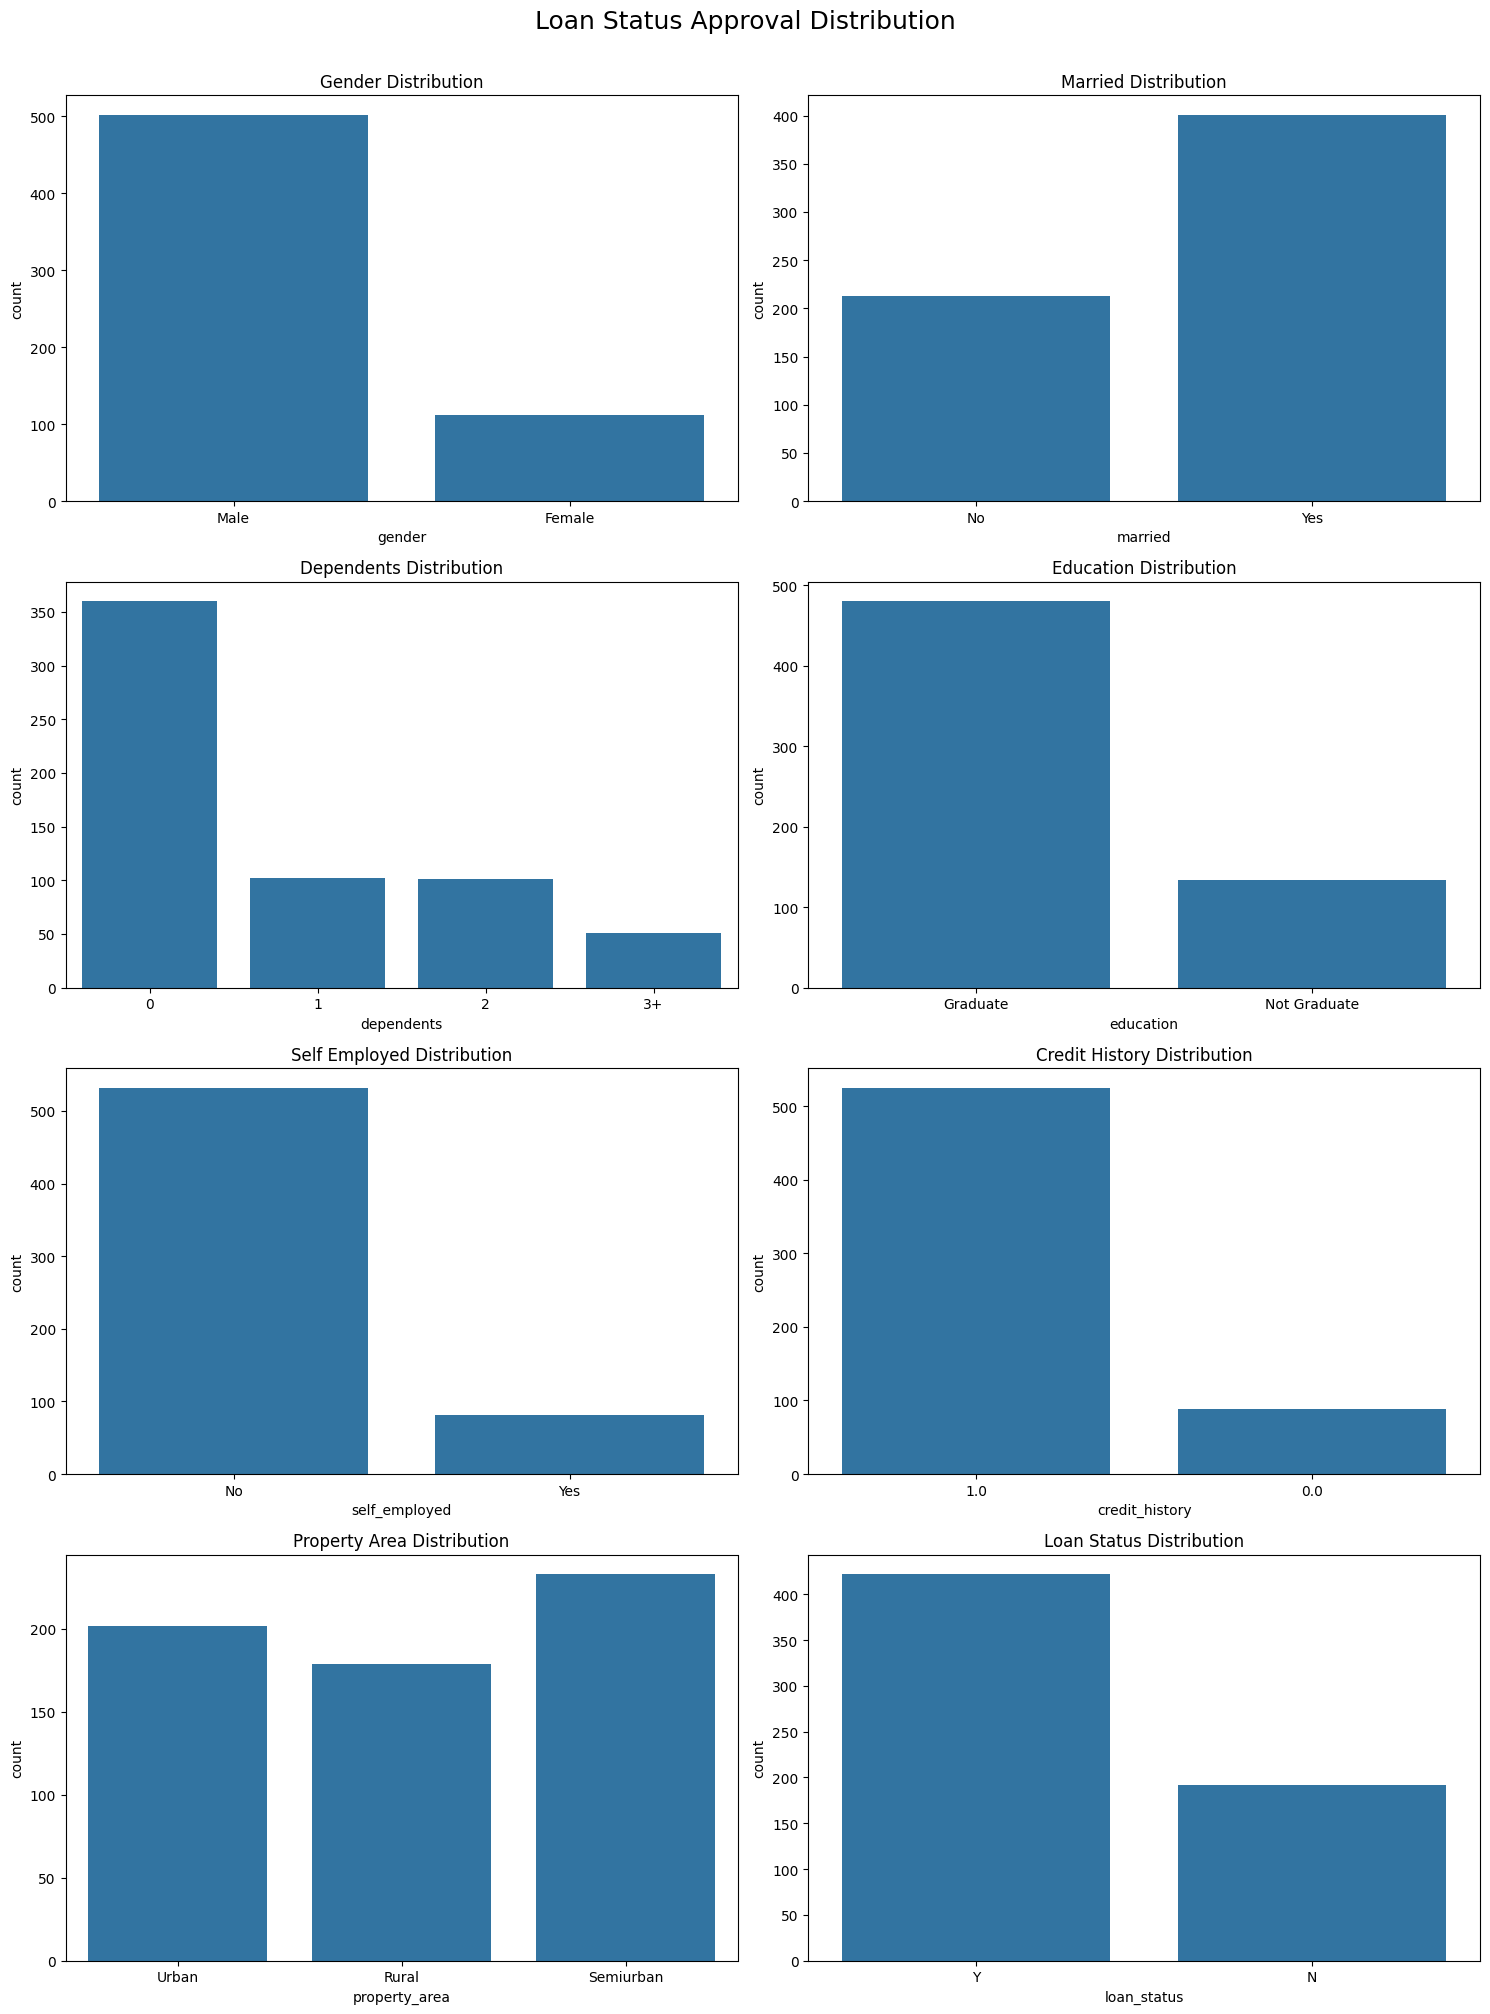

In [15]:
to_neat_column_name = lambda col: ' '.join([word.capitalize() for word in col.split("_")])

num_cols = 2
num_rows = int((len(categorical_columns) + 1)/num_cols)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 20))

if num_rows == 1:
    axs = [axs]

for i, column in enumerate(categorical_columns):
    sns.countplot(x=column, data=df, ax=axs[int(i / num_cols)][i % num_cols])
    axs[int(i / num_cols)][i % num_cols].set_title(f'{to_neat_column_name(column)} Distribution')

plt.suptitle("Loan Status Approval Distribution", fontsize=18, y=1.005)
plt.tight_layout()
plt.show()

### 2.1.2. Numeric Data

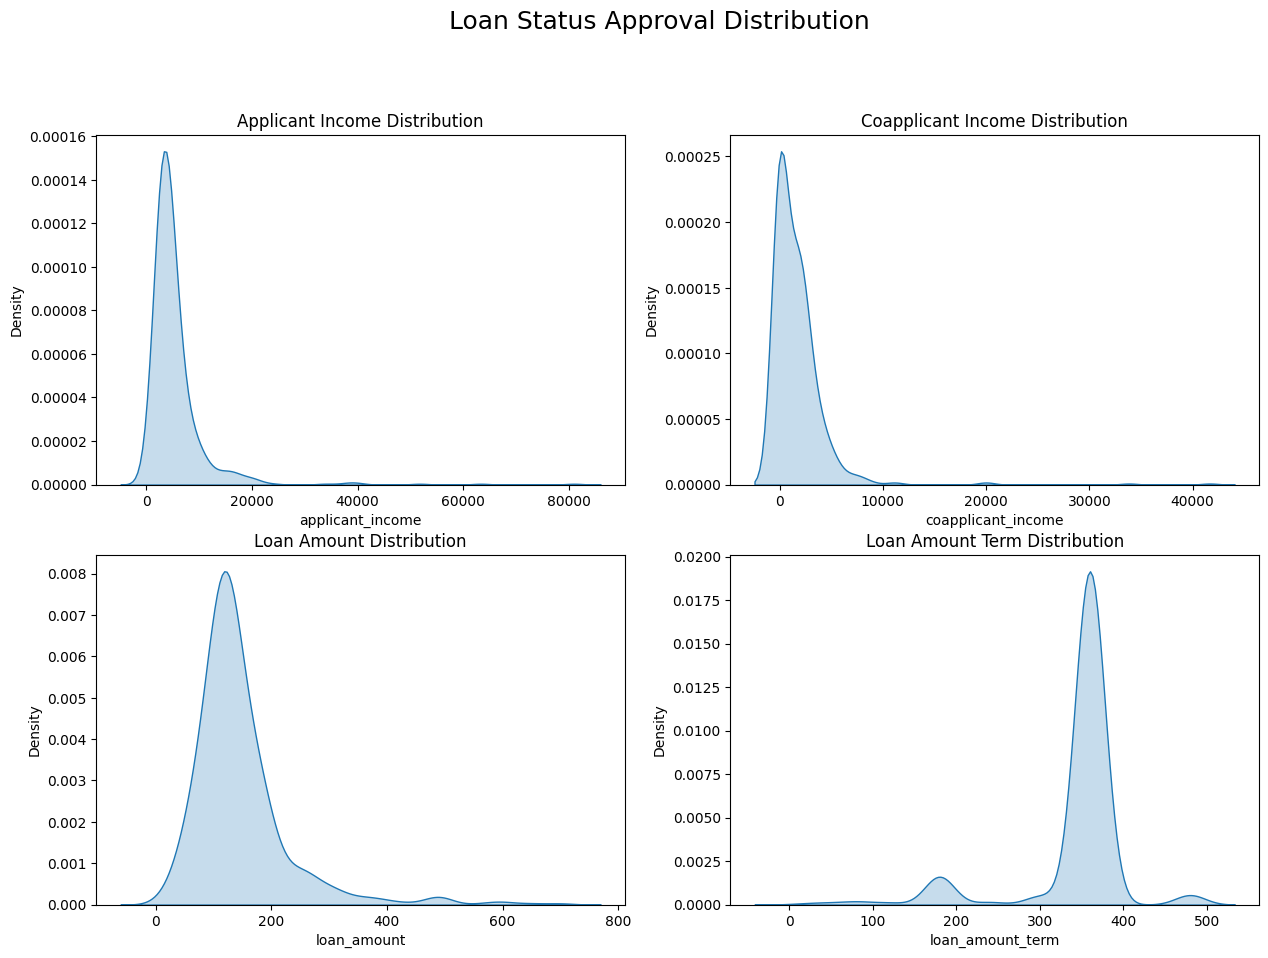

In [16]:
num_cols = 2
num_rows = int((len(numeric_columns) + 1)/num_cols)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10))

if num_rows == 1:
    axs = [axs]

for i, column in enumerate(numeric_columns):
    sns.kdeplot(data=df, x=column, ax=axs[int(i / num_cols)][i % num_cols], fill=True)
    axs[int(i / num_cols)][i % num_cols].set_title(f'{to_neat_column_name(column)} Distribution')

plt.suptitle("Loan Status Approval Distribution", fontsize=18, y=1.005)
plt.show()

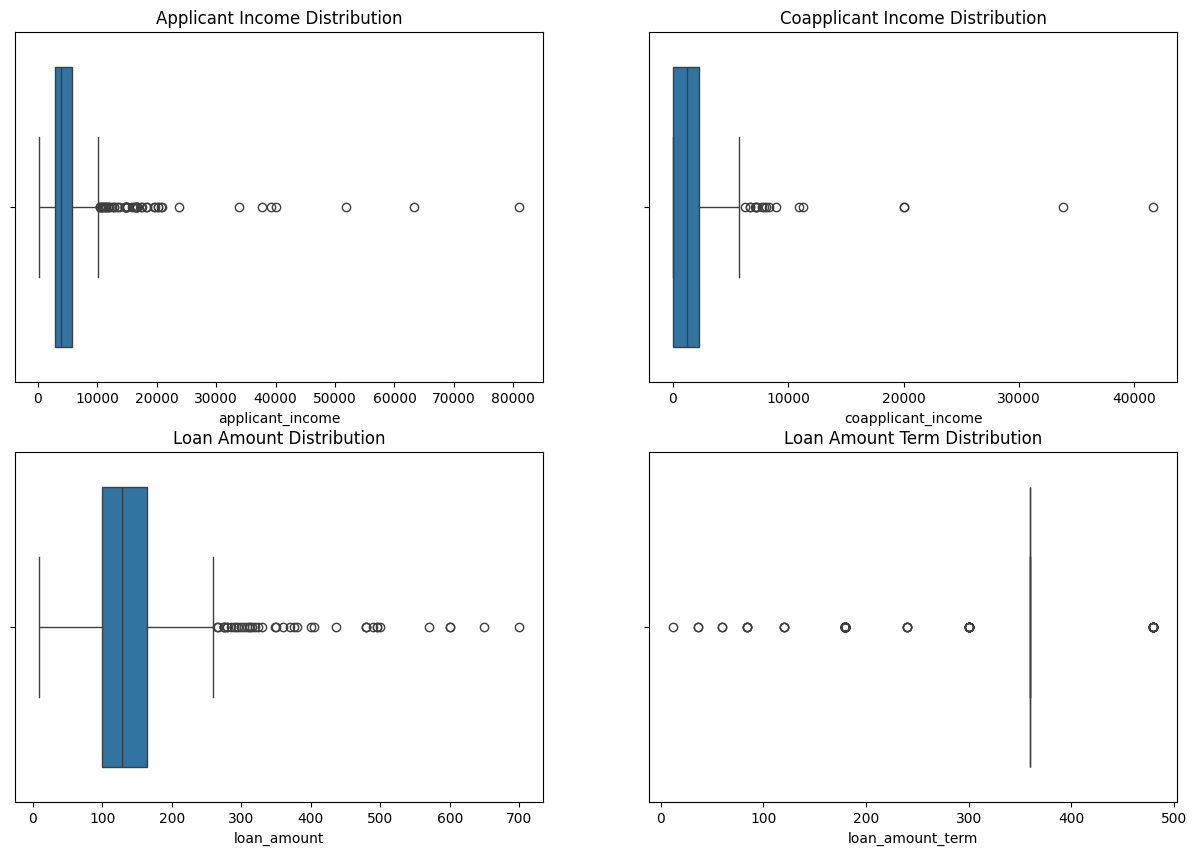

In [17]:
num_cols = 2
num_rows = int((len(numeric_columns) + 1)/num_cols)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10))

if num_rows == 1:
    axs = [axs]

for i, column in enumerate(numeric_columns):
    sns.boxplot(data=df, x=column, ax=axs[int(i / num_cols)][i % num_cols])
    axs[int(i / num_cols)][i % num_cols].set_title(f'{to_neat_column_name(column)} Distribution')
    
plt.show()

## 2.2. Transform data

### 2.2.1. Categorical data

From analysing the data we can conclude that all of our `"categorical"` data can be described as either binary, or ordinal, we can therefore encode them with a label encoder and still receive accurate results, while not overextending the size of the overall dataset.

In [18]:
label_encoder = LabelEncoder()
for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col])

### 2.2.2. Numeric data

In [19]:
standard_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()
for col in numeric_columns:
    df[col] = min_max_scaler.fit_transform(df[[col]])

## 2.3. Bivariate analysis

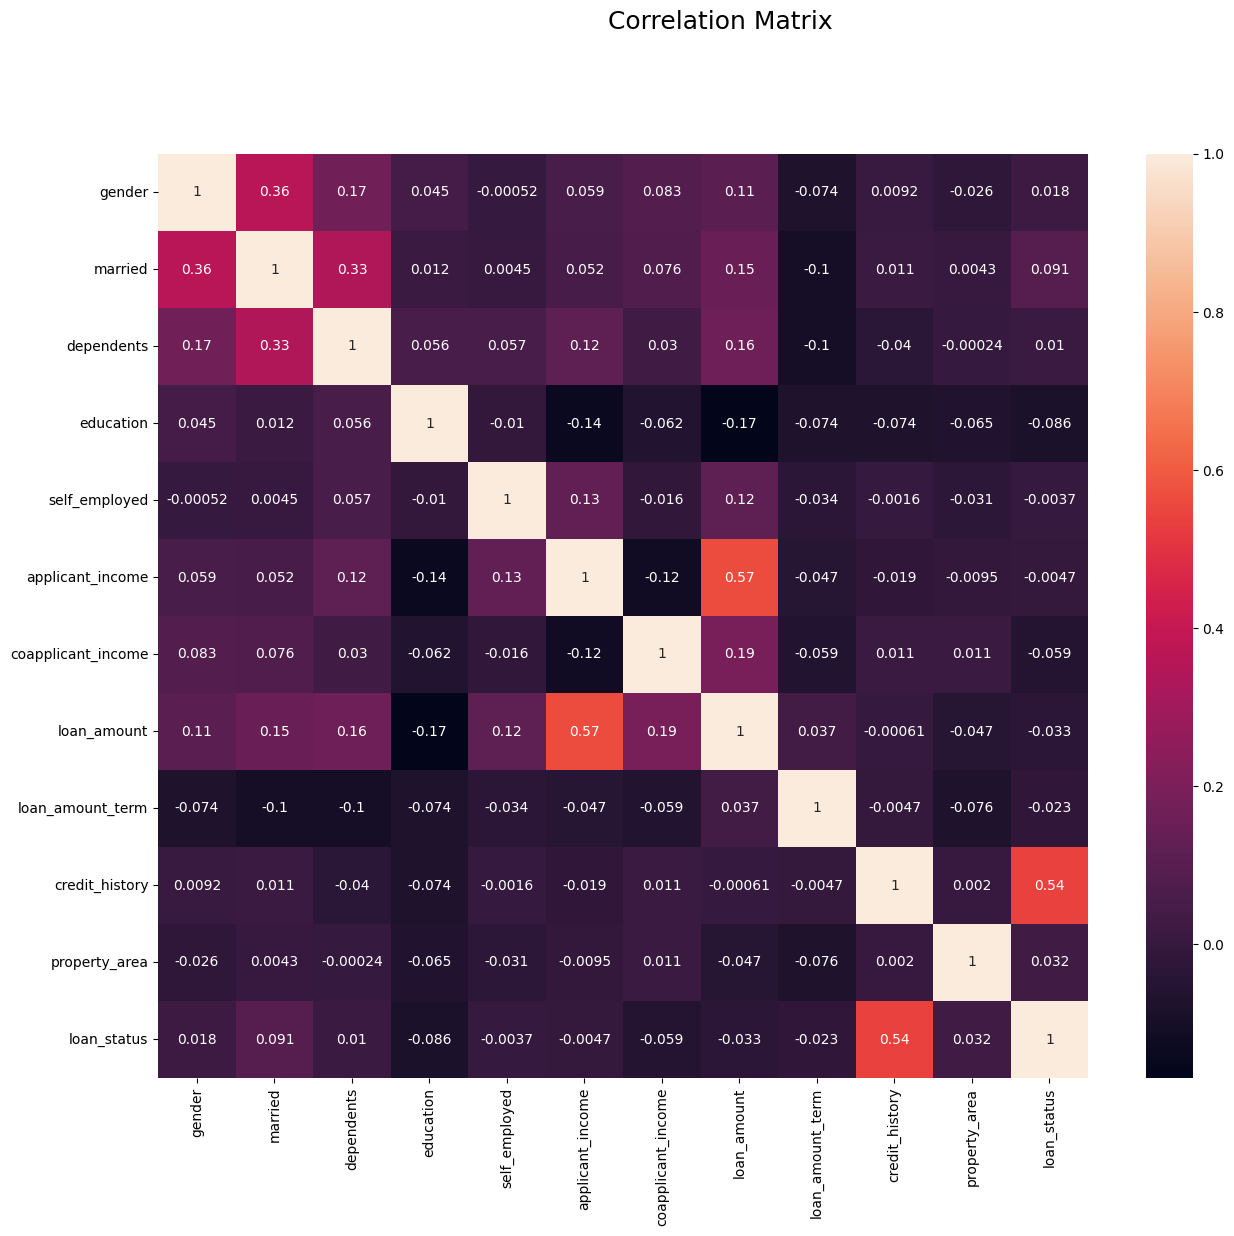

In [20]:
correlation_matrix = df.corr()
plt.figure(figsize=(15,12))
fig = sns.heatmap(data = correlation_matrix, annot=True)
plt.suptitle('Correlation Matrix', fontsize=18, y=1)
plt.show()

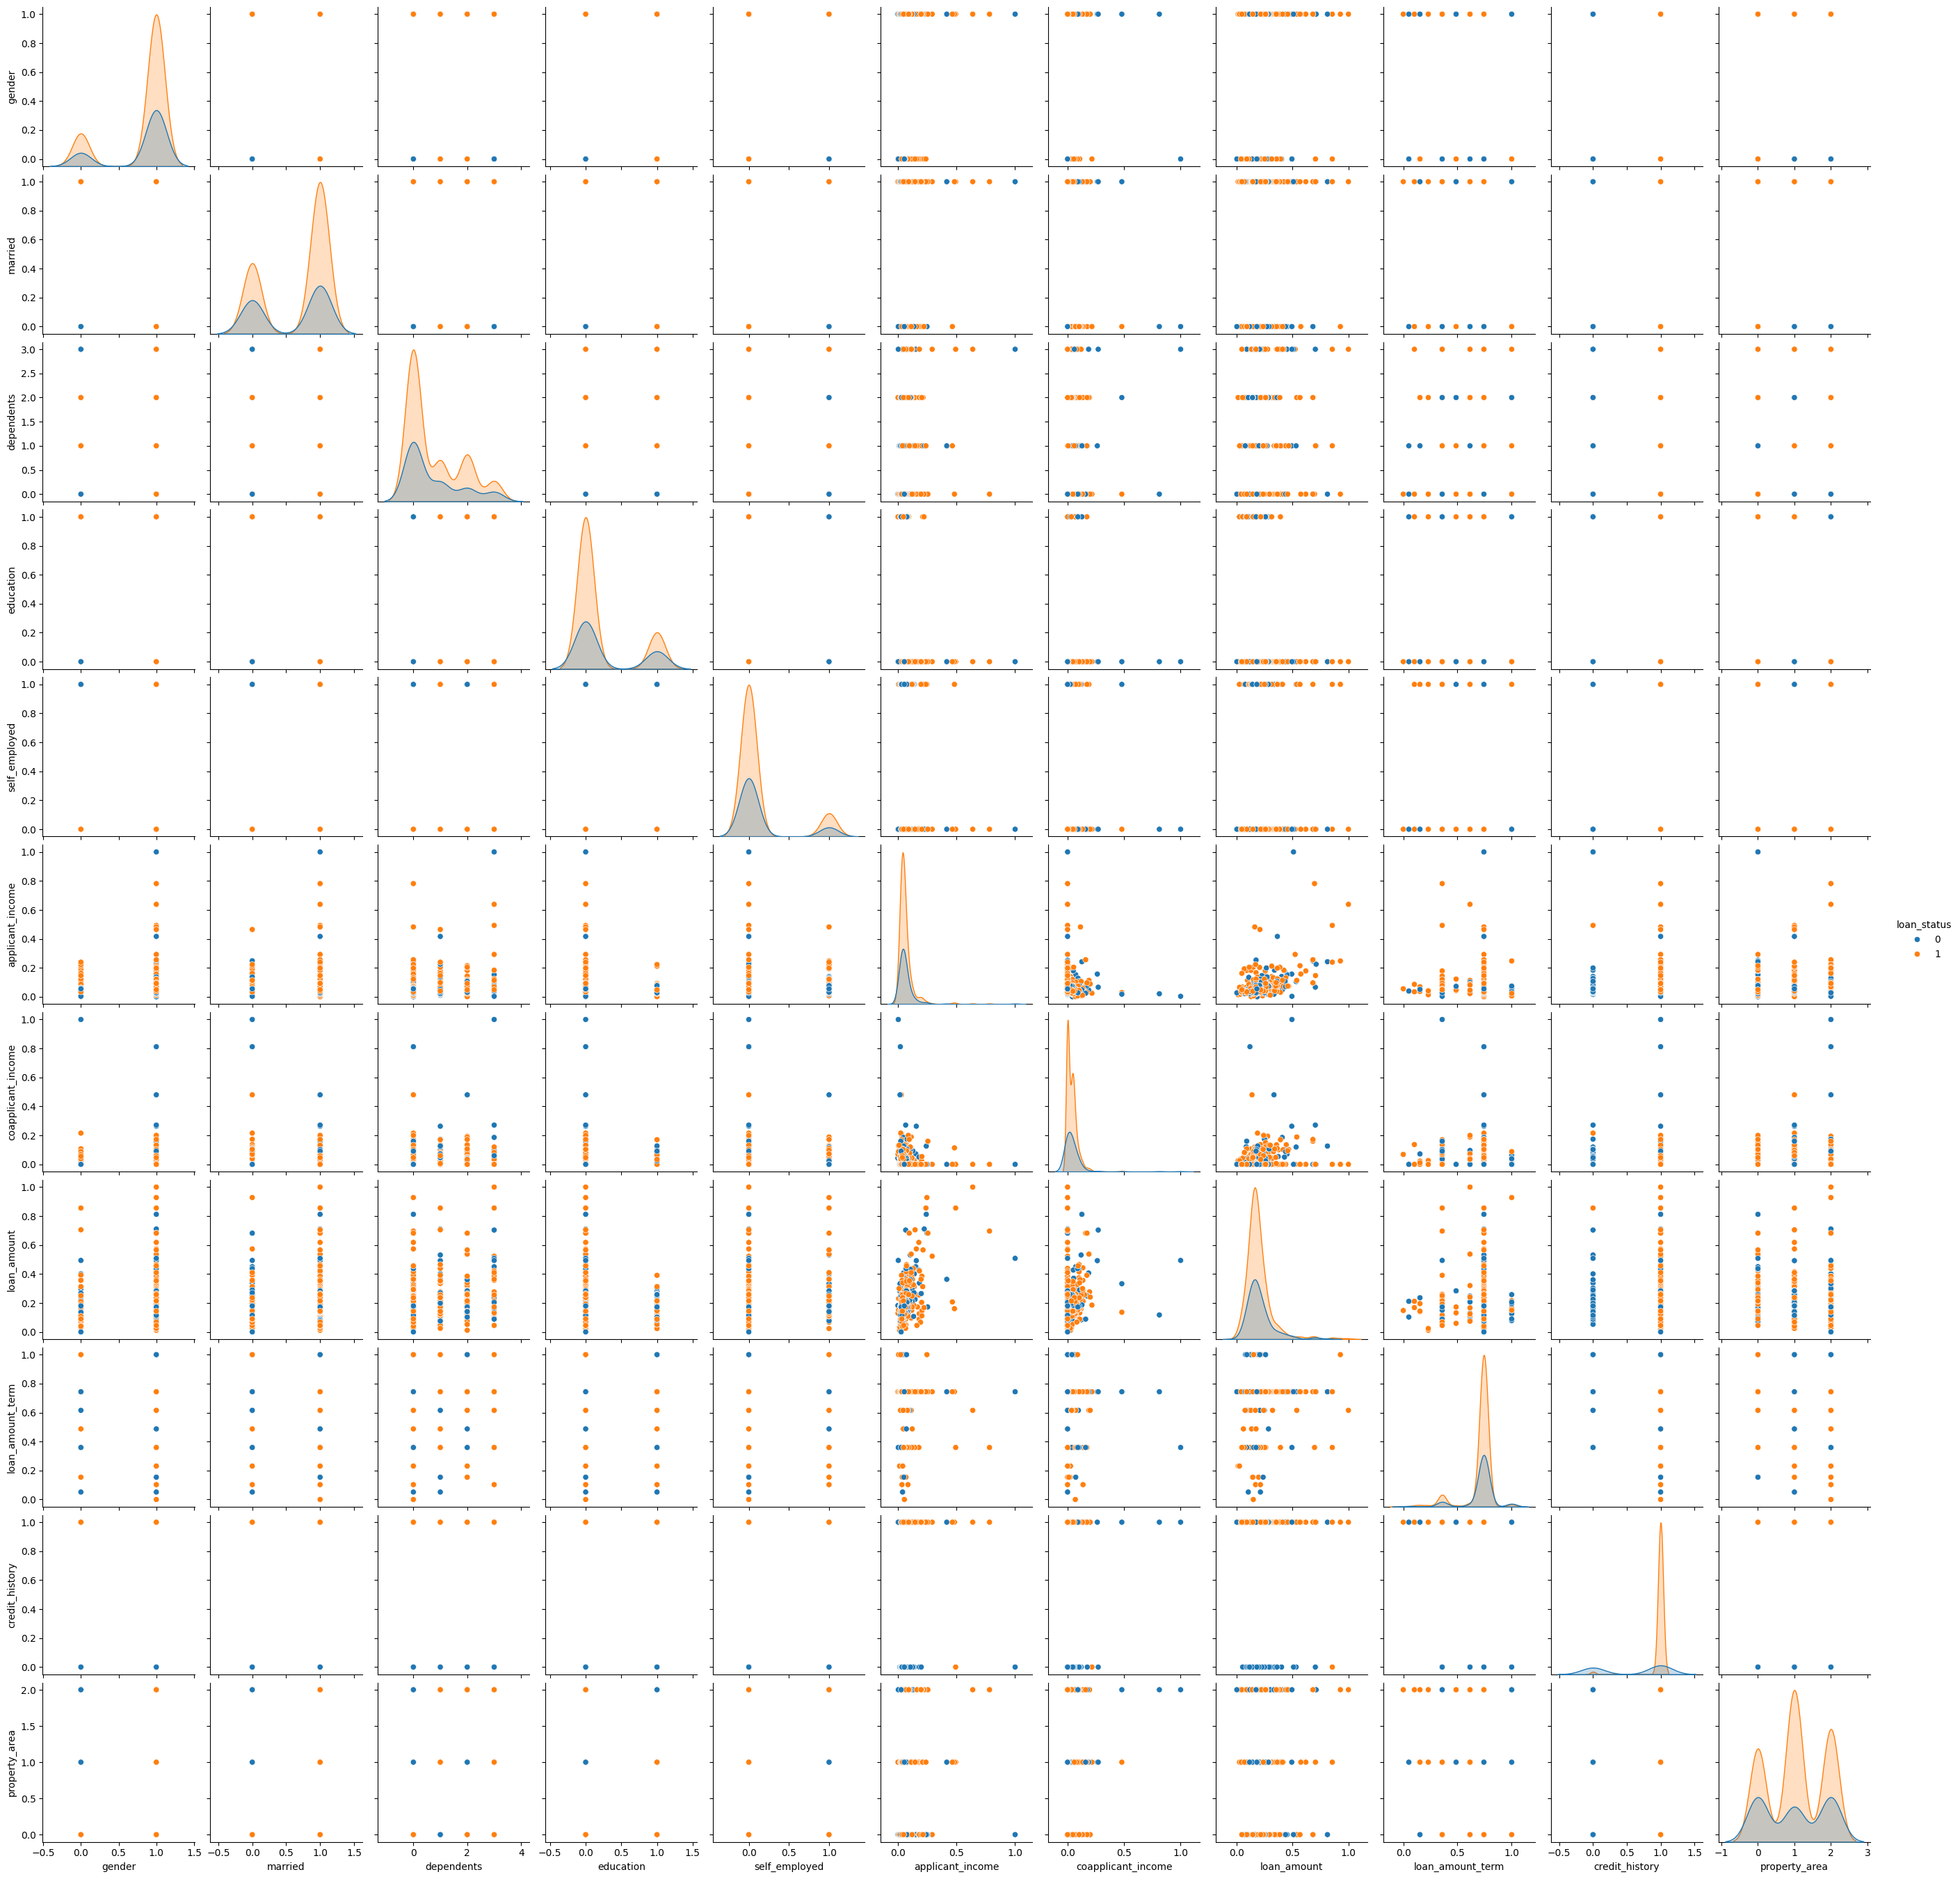

In [21]:
sns.pairplot(data=df, hue="loan_status")

# 3. Machine Learning Model Implementation

## 3.1. Streamline Transformation

This will help ensure that there is an easy way to clean and transform any new data, might that be data that needs to be predicted, or that needs to be fit to the model.

### 3.1.1. Tokenize Data

In [62]:
def prepare_data(actual_df):
    df = actual_df.copy()
    label_encoder = LabelEncoder()
    categorical_columns = ['gender', 'married', 'dependents', 'education', 'self_employed', 'credit_history', 'property_area']
    numeric_columns = ['applicant_income', 'coapplicant_income', 'loan_amount', 'loan_amount_term']
    
    for col in categorical_columns:
        df[col] = df[col].fillna(df[col].mode()[0])
    for col in numeric_columns:
        df[col] = df[col].fillna(df[col].median())
        
    return df[categorical_columns + numeric_columns]

### 3.1.2. Transform Data

In [63]:
def preprocess_data(actual_df):
    categorical_columns = ['gender', 'married', 'dependents', 'education', 'self_employed', 'credit_history', 'property_area']
    numeric_columns = ['applicant_income', 'coapplicant_income', 'loan_amount', 'loan_amount_term']
    df = actual_df.copy()
    df = prepare_data(df)
    for col in categorical_columns:
        df[col] = label_encoder.fit_transform(df[col])
    return df

## 3.2. Modelling

### 3.2.1. Streamline Process Creating Model

We need create a function that will make it easy to evaluate the model with different parameters.

In [64]:
def create_ANN(df, model):
    X = df.drop(columns=['loan_status'], axis=1)
    y = LabelEncoder().fit_transform(df['loan_status'])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    X_train = preprocess_data(X_train)
    X_test = preprocess_data(X_test)    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True
    )

    history = model.fit(X_train, y_train, epochs=250, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)    
    print("done...")
    return (model, history, X_train, X_test, y_train, y_test)

### 3.2.2. Create The Initial Model

In [65]:
df = clean_columns(pd.read_csv('../data/raw_data.csv'))
categorical_columns = ['gender', 'married', 'dependents', 'education', 'self_employed', 'credit_history', 'property_area']
numeric_columns = ['applicant_income', 'coapplicant_income', 'loan_amount', 'loan_amount_term']
(model, history, X_train, X_test, y_train, y_test) = create_ANN(
        df,
        tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(11,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ]))

model_nr = 1
output_dir = f'../artifacts/model_{model_nr}.pkl'
with open(output_dir, 'wb') as file:
    pickle.dump(model, file)

df_val = clean_columns(pd.read_csv('../data/validation.csv'))
X = preprocess_data(df_val)
df_val['loan_status'] = ['Y' if val > 0.5 else 'N' for val in model.predict(X)]
df_val.to_csv(f'../artifacts/predictions_{model_nr}.csv', sep=',')

done...
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


## 3.3. Model Evaluation

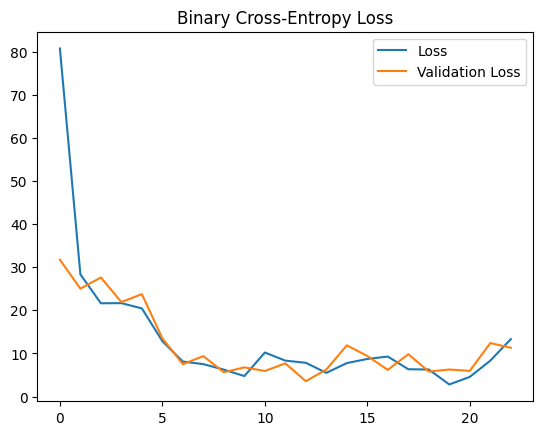

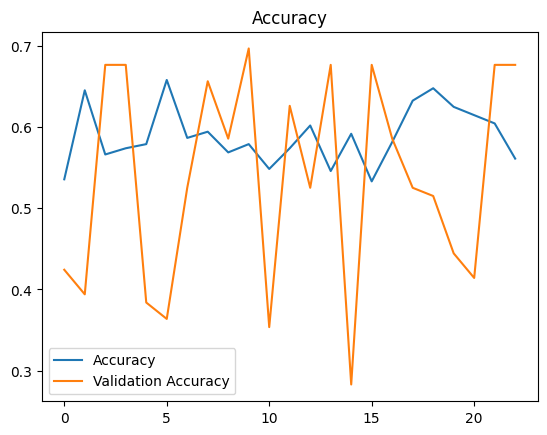

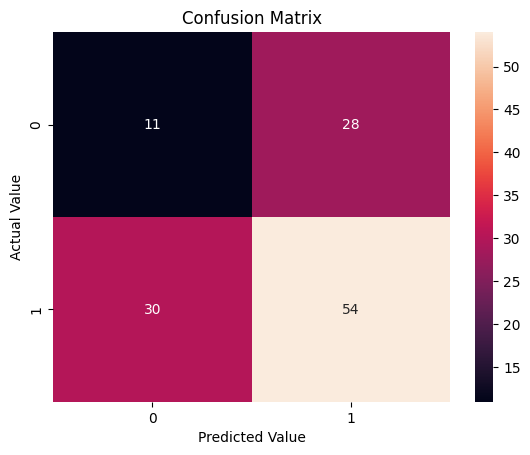

Performance Metrics:
Accuracy: 0.5285
Loss: 3.9400
Precision: 0.6585
Recall: 0.6429
F1-score: 0.6506


In [66]:
def score(y_true, y_pred_proba):
    y_pred = (y_pred_proba >= 0.5).astype(int)
    accuracy = accuracy_score(y_true, y_pred)
    return accuracy

def get_feature_importance(model, X_val, y_val):
    def scoring_wrapper(estimator, X, y):
        y_pred_proba = estimator.predict(X)
        return score(y, y_pred_proba)
    result = permutation_importance(model, X_val, y_val, scoring=scoring_wrapper, n_repeats=10, random_state=42)
    categorical_columns = ['gender', 'married', 'dependents', 'education', 'self_employed', 'credit_history', 'property_area']
    numeric_columns = ['applicant_income', 'coapplicant_income', 'loan_amount', 'loan_amount_term']
    return pd.DataFrame({'attribute': categorical_columns+numeric_columns, 'importance': result.importances_mean})
    
def get_model_performance(model, history, X_test, y_test):
    y_pred_proba = model.predict(X_test, verbose=0)
    y_pred = [1 if val > 0.5 else 0 for val in y_pred_proba]
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(["Loss", "Validation Loss"])
    plt.title("Binary Cross-Entropy Loss")
    plt.show()
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.legend(["Accuracy", "Validation Accuracy"])
    plt.title("Accuracy")
    plt.show()
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True)
    plt.xlabel('Predicted Value')
    plt.ylabel('Actual Value')
    plt.title("Confusion Matrix")
    plt.show()
    
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print("Performance Metrics:")
    print("="*50)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Loss: {loss:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

def get_model_performance_minimal(model, X_test, y_test):
    y_pred_proba = model.predict(X_test, verbose=0)
    y_pred = [1 if val > 0.5 else 0 for val in y_pred_proba]
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print("Performance Metrics:")
    print("="*50)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Loss: {loss:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

get_model_performance(model, history, X_test, y_test)

In [67]:
model_nr = 1
output_dir = f'../artifacts/model_{model_nr}.pkl'
with open(output_dir, 'wb') as file:
    pickle.dump(model, file)

df_val = clean_columns(pd.read_csv('../data/validation.csv'))
X = preprocess_data(df_val)
df_val['loan_status'] = ['Y' if val > 0.5 else 'N' for val in model.predict(X)]
df_val.to_csv(f'../artifacts/predictions_{model_nr}.csv', sep=',')

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


## 3.4. Improve with feature engineering

### 3.4.1. Feature Engineering

We can improve the model by:
- Scaling

In [68]:
def preprocess_data(actual_df):
    df = actual_df.copy()
    df = prepare_data(df)
    standard_scaler = StandardScaler()
    
    categorical_columns = ['gender', 'married', 'dependents', 'education', 'self_employed', 'credit_history', 'property_area']
    numeric_columns = ['applicant_income', 'coapplicant_income', 'loan_amount', 'loan_amount_term']
    for col in categorical_columns:
        df[col] = label_encoder.fit_transform(df[col])
    df = standard_scaler.fit_transform(df)
    return df

### 3.4.2. Create Improved Model 

In [69]:
df = clean_columns(pd.read_csv('../data/raw_data.csv'))
categorical_columns = ['gender', 'married', 'dependents', 'education', 'self_employed', 'credit_history', 'property_area']
numeric_columns = ['applicant_income', 'coapplicant_income', 'loan_amount', 'loan_amount_term']
(model, history, X_train, X_test, y_train, y_test) = create_ANN(
        df,
        tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(len(categorical_columns + numeric_columns),)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ]))

model_nr = 2
output_dir = f'../artifacts/model_{model_nr}.pkl'
with open(output_dir, 'wb') as file:
    pickle.dump(model, file)

df_val = clean_columns(pd.read_csv('../data/validation.csv'))
X = preprocess_data(df_val)
df_val['loan_status'] = ['Y' if val > 0.5 else 'N' for val in model.predict(X)]
df_val.to_csv(f'../artifacts/predictions_{model_nr}.csv', sep=',')

done...
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


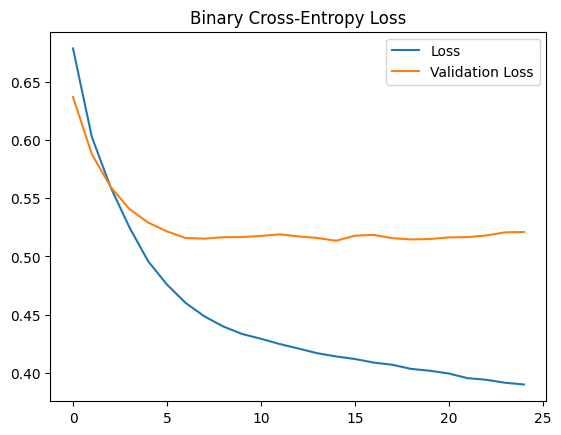

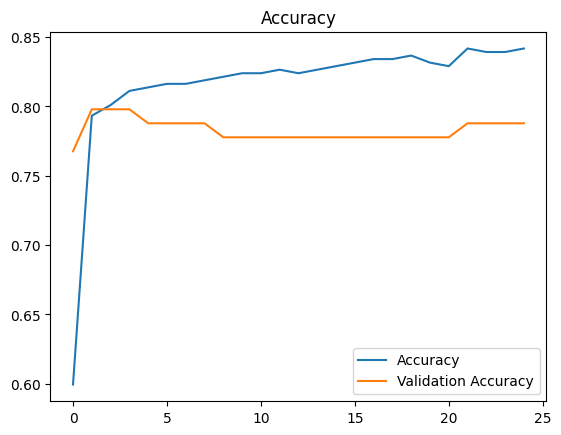

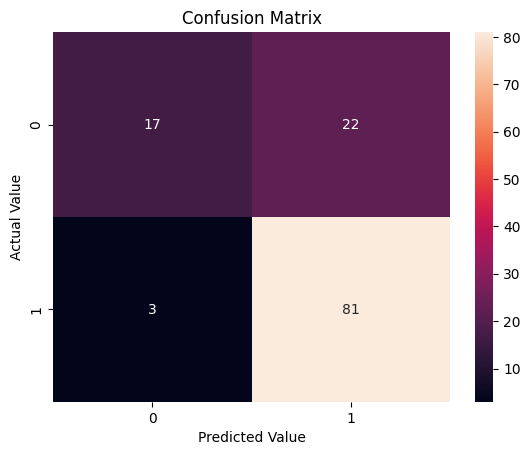

Performance Metrics:
Accuracy: 0.7967
Loss: 0.5035
Precision: 0.7864
Recall: 0.9643
F1-score: 0.8663


In [70]:
get_model_performance(model, history, X_test, y_test)

In [ ]:
feature_importance = get_feature_importance(model, X_test, y_test).sort_values(by='importance', ascending=False)
feature_importance = feature_importance.reset_index(drop=True)
feature_importance.to_csv('../artifacts/feature_importance.csv', sep=',', index=True)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━

In [ ]:
def create_logistic(df):
    X = df.drop(columns=['loan_status'], axis=1)
    y = LabelEncoder().fit_transform(df['loan_status'])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    X_train = preprocess_data(X_train)
    X_test = preprocess_data(X_test)    
    logistic_model = LogisticRegression()
    logistic_model.fit(X_train, y_train)    
    print("done...")
    return (logistic_model, X_train, X_test, y_train, y_test)

In [ ]:
df = clean_columns(pd.read_csv('../data/raw_data.csv'))
categorical_columns = ['gender', 'married', 'dependents', 'education', 'self_employed', 'credit_history', 'property_area']
numeric_columns = ['applicant_income', 'coapplicant_income', 'loan_amount', 'loan_amount_term']
(model, X_train, X_test, y_train, y_test) = create_logistic(df)

In [ ]:
y_pred = [1 if val > 0.5 else 0 for val in model.predict(X_test)]
print(y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

In [ ]:
model_nr = 3
output_dir = f'../artifacts/model_{model_nr}.pkl'
with open(output_dir, 'wb') as file:
    pickle.dump(model, file)

df_val = clean_columns(pd.read_csv('../data/validation.csv'))
X = preprocess_data(df_val)
df_val['loan_status'] = ['Y' if val > 0.5 else 'N' for val in model.predict(X)]
df_val.to_csv(f'../artifacts/predictions_{model_nr}.csv', sep=',')